# xg_modelling.ipynb
Given input shot data from xg_shot_input_2015-2023.csv, train, test, and plot the results from an expected goals model.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import root_mean_squared_error
from xgboost import XGBRegressor
import pickle
import shap

In [2]:
# Load data from CSV file
XG_data = pd.read_csv('../data/xg_shot_input_2015-2023.csv')

In [3]:
# Split data into features (X) and target (y)
y = XG_data['isGoal']
X = XG_data.drop(columns=['isGoal'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [4]:
# Bool for whether or not to use a previously trained model
use_saved_model = 1

# Without saved weights, train a model
if use_saved_model == 0:
     print("No model trained. Training a model and saving weights in xg_model.pkl")
     # Define base estimators for StackingRegressor
     estimators = [
          ('xgb', XGBRegressor(objective='reg:squarederror', random_state=42)),
          ('ridge', Ridge(alpha=3)),
          ('lasso', Lasso(alpha=0.5)),
          #('rf', RandomForestRegressor(n_estimators=100, random_state=42))
     ]

     # Create and train the StackingRegressor
     reg = StackingRegressor(estimators=estimators, verbose=1)
     reg.fit(X_train, y_train)

     # Save the model weights using pickle
     with open('xg_model.pkl','wb') as f:
          pickle.dump(reg,f)

# Else, load the saved model weights
else:
     print("Model already trained. Using saved model weights from xg_model.pkl")
     with open('xg_model.pkl', 'rb') as f:
          reg = pickle.load(f)

Model already trained. Using saved model weights from xg_model.pkl


In [5]:
# Make predictions on the test set
y_pred = reg.predict(X_test)

In [6]:
# Calculate root mean squared error (RMSE) on the test set
reg_rmse = root_mean_squared_error(y_test, y_pred)
print("Stacked Model RMSE:", reg_rmse)

Stacked Model RMSE: 0.2411665839068776


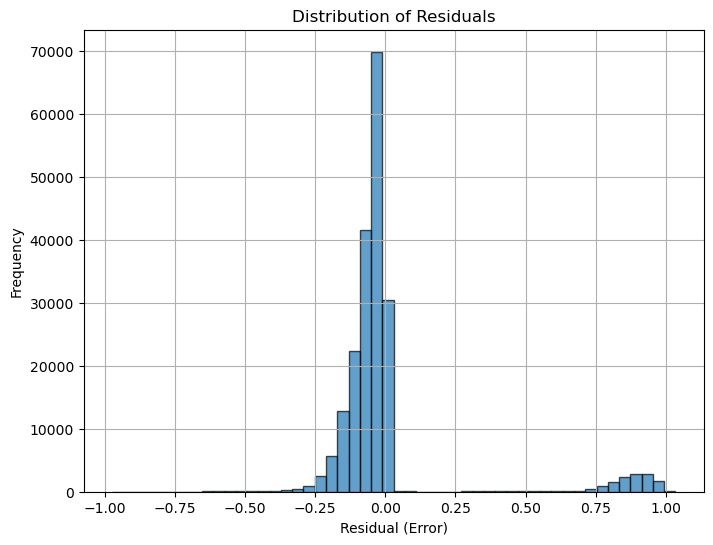

In [7]:
# Plot histogram of residuals
residuals = y_test - y_pred
plt.figure(figsize=(8,6))
plt.hist(residuals, bins=50, edgecolor='k', alpha=0.7)
plt.title('Distribution of Residuals')
plt.xlabel('Residual (Error)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [8]:
# TODO: Plotting of results
# TODO: Plotting of feature importance with SHAP: https://shap.readthedocs.io/en/latest/
     # Beeswarm, waterfall